This example illustrates the effect of the parameters gamma and C of the Radial Basis Function (RBF) kernel SVM. RBF kernels tend to work better than other kernels on most problems in practice, which is why it's interesting to dig a little deeper into how they work.

Intuitively, the gamma parameter defines how far the influence of a single training example reaches, with low values meaning 'far' and high values meaning 'close'.

The C parameter trades off correct classification of training examples against maximization of the decision function's margin. For larger values of C, a smaller margin will be accepted if the decision function is better at classifying all training points correctly. A lower C will encourage a larger margin, therefore a simpler decision function, at the cost of training accuracy. In other wordsC behaves as a regularization parameter in the SVM.

This exercise will guide you through visualizing the effect of those two parameters on the way an SVM model classifies data.

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

Load the iris dataset from sklearn and create an object X containing the explanatory variables and an object y containing the target variable.

In [70]:
iris = load_iris()
X = iris.data
y = iris.target
print(X[:5])
print(y[:5])

[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]]
[0 0 0 0 0]


Since this exercise is about visualizing decision boundaries of SVM models and the effect of penalization parameters C and gamma, we will simplify the data a little. First keep only the first two columns of X and filter observations so that you only have two different classes for the target variable. This will make it easy to visualize our data, and the predictions of the model.

In [71]:
X_2d = X[:, :2] # keep first two features
X_2d = X_2d[y > 0] # remove class 0 observations from X
y_2d = y[y > 0] # remove class 0 observations from y
y_2d -= 1 # set values of y from {1,2} to {0,1}

Separate the data between a training set and a test set, then normalize the data. Why is it important to scale the data when using SVM models, especially with non-linear kernels?

In [72]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, random_state=0)
scaler = StandardScaler()
Xtrain = scaler.fit_transform(X_train)
Xtest = scaler.transform(X_test)

Create a list C_range containing the values 0.01, 1 , 100 and a list gamma_range that contains the values 0.1, 1 and 10

In [73]:
C_range = [1e-2, 1, 1e2]
gamma_range = [1e-1, 1, 1e1]
print(C_range)
print(gamma_range)

[0.01, 1, 100.0]
[0.1, 1, 10.0]


Create an empty list called classifiers, then loop over C_range and gamma_range and train an sklearn.svm.SVC model on Xtrain and ytrain to form a collection of tuples of the form (value of C, value of gamma, trained svc model) all stored in the list classifiers.

In [74]:
classifiers = []
for C in C_range:
    for gamma in gamma_range:
        clf = SVC(C=C, gamma=gamma)
        clf.fit(Xtrain, Y_train)
        classifiers.append((C, gamma, clf))

print(classifiers)

[(0.01, 0.1, SVC(C=0.01, gamma=0.1)), (0.01, 1, SVC(C=0.01, gamma=1)), (0.01, 10.0, SVC(C=0.01, gamma=10.0)), (1, 0.1, SVC(C=1, gamma=0.1)), (1, 1, SVC(C=1, gamma=1)), (1, 10.0, SVC(C=1, gamma=10.0)), (100.0, 0.1, SVC(C=100.0, gamma=0.1)), (100.0, 1, SVC(C=100.0, gamma=1)), (100.0, 10.0, SVC(C=100.0, gamma=10.0))]


Use the np.meshgrid function and np.linspace function in order to create an object xx and an object yy both of shape (200,200) that uniformely map the two dimensional square defined by (x,y)∀x∈[−3,3],y∈[−3,3]


In [75]:
xx, yy = np.meshgrid(np.linspace(-3, 3, 200), np.linspace(-3, 3, 200))
print(xx)

[[-3.         -2.96984925 -2.93969849 ...  2.93969849  2.96984925
   3.        ]
 [-3.         -2.96984925 -2.93969849 ...  2.93969849  2.96984925
   3.        ]
 [-3.         -2.96984925 -2.93969849 ...  2.93969849  2.96984925
   3.        ]
 ...
 [-3.         -2.96984925 -2.93969849 ...  2.93969849  2.96984925
   3.        ]
 [-3.         -2.96984925 -2.93969849 ...  2.93969849  2.96984925
   3.        ]
 [-3.         -2.96984925 -2.93969849 ...  2.93969849  2.96984925
   3.        ]]


Use the function np.c_ in order to transform xx and yy into a list of coordinates (a list of [x,y]) mapping the space, and store it under the name . You will need to transform xx and yy for this to work.

In [76]:
sample_grid = np.c_[xx.ravel(), yy.ravel()]
# Étendre sample_grid pour avoir 4 colonnes
sample_grid_extended = np.c_[sample_grid, np.zeros((sample_grid.shape[0], 2))]

# Calculer la fonction de décision avec les 4 caractéristiques
sample_grid_extended

array([[-3.        , -3.        ,  0.        ,  0.        ],
       [-2.96984925, -3.        ,  0.        ,  0.        ],
       [-2.93969849, -3.        ,  0.        ,  0.        ],
       ...,
       [ 2.93969849,  3.        ,  0.        ,  0.        ],
       [ 2.96984925,  3.        ,  0.        ,  0.        ],
       [ 3.        ,  3.        ,  0.        ,  0.        ]])

Apply the method .decision_function from the seventh element of classifiers to sample_grid, what comes out ? Store this value in an object named Z. Check the decision_function documentation to learn more.

In [77]:
_,_,classif = classifiers[6]
Z = classif.decision_function(sample_grid_extended)
Z

array([[-0.09926086,  1.03483909,  2.07836351],
       [-0.10192946,  1.03306433,  2.08277595],
       [-0.10455935,  1.0313691 ,  2.08699611],
       ...,
       [ 0.95728008,  1.23396967,  0.77058389],
       [ 0.95682669,  1.23310837,  0.77158546],
       [ 0.95641746,  1.23224314,  0.77258861]])

Plot -Z using the pcolormesh function, xx, yy, and cmap=plt.cm.RdBu

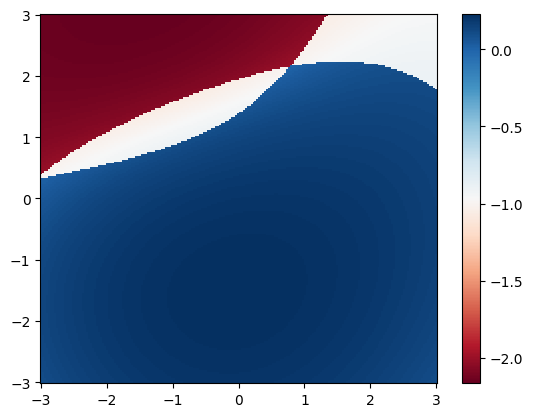

In [78]:
Z = Z[:, 0]  # Sélectionner la première classe pour la visualisation
Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, -Z, cmap=plt.cm.RdBu)
plt.colorbar()
plt.show()

In order to put this in context, add to the same graph the coordinates of your observations with a different color for each category of y, you can use the argument : cmap=plt.cm.RdBu_r

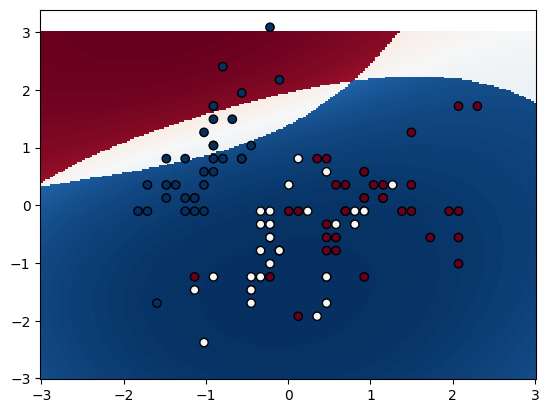

In [79]:
plt.pcolormesh(xx,yy,-Z.reshape(xx.shape),cmap=plt.cm.RdBu)
plt.scatter(Xtrain[:, 0], Xtrain[:, 1], c=Y_train, cmap=plt.cm.RdBu_r,
                edgecolors='k')

Add another plot that draws the decision boundary of our model.

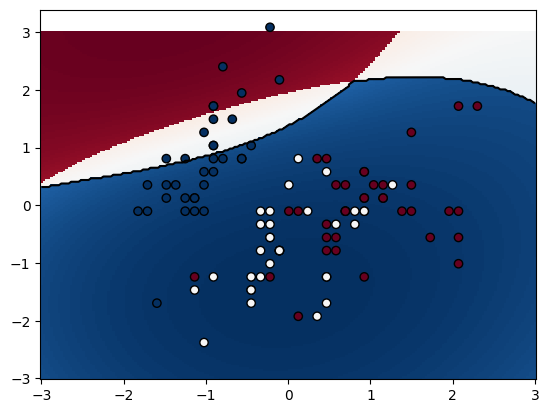

In [80]:
plt.pcolormesh(xx,yy,-Z.reshape(xx.shape),cmap=plt.cm.RdBu)
plt.scatter(Xtrain[:, 0], Xtrain[:, 1], c=Y_train, cmap=plt.cm.RdBu_r,
                edgecolors='k')
plt.contour(xx,yy,Z.reshape(xx.shape), levels = [0.0], colors ="black")

Loop over enumerate(classifiers) to produce a similar figure for each of the different classifiers

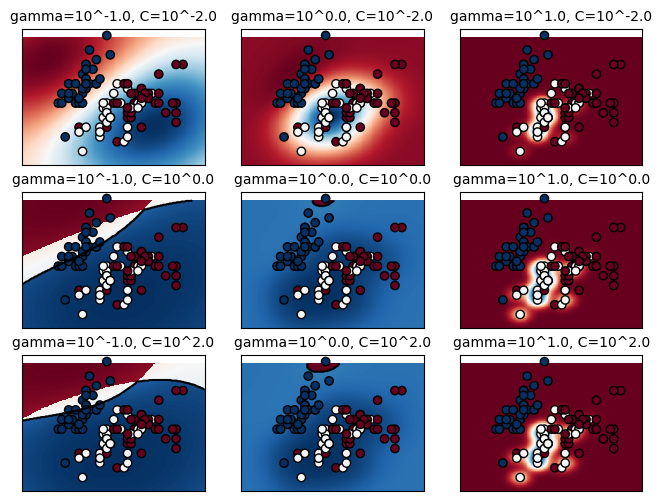

In [81]:
plt.figure(figsize=(8, 6))
for (k, (C, gamma, clf)) in enumerate(classifiers):
    # Évaluer la fonction de décision dans la grille
    Z = clf.decision_function(sample_grid_extended)
    Z = Z[:, 0]  # Utiliser uniquement la première colonne si plusieurs colonnes
    Z = Z.reshape(xx.shape)

    # Visualiser la fonction de décision pour ces paramètres
    plt.subplot(len(C_range), len(gamma_range), k + 1)
    plt.title("gamma=10^{0}, C=10^{1}".format(np.log10(gamma), np.log10(C)),
              size='medium')

    # Visualiser l'effet des paramètres sur la fonction de décision
    plt.pcolormesh(xx, yy, -Z, cmap=plt.cm.RdBu)
    plt.scatter(Xtrain[:, 0], Xtrain[:, 1], c=Y_train, cmap=plt.cm.RdBu_r,
                edgecolors='k')
    plt.contour(xx, yy, Z, levels=[0.0], colors="black")
    plt.xticks(())
    plt.yticks(())
    plt.axis('tight')

plt.show()

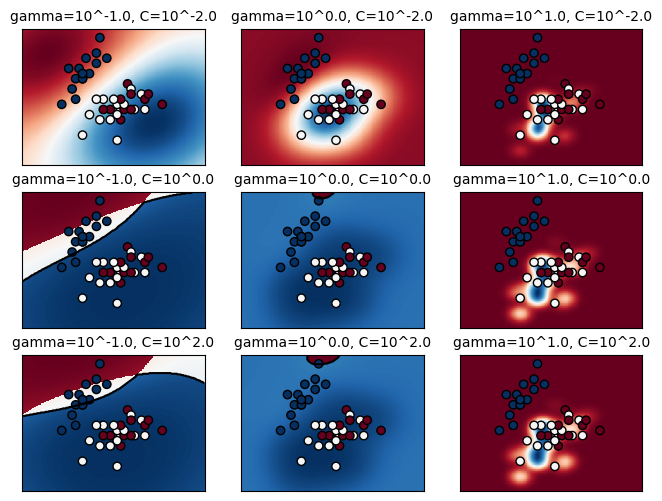

In [82]:
plt.figure(figsize=(8, 6))
for (k, (C, gamma, clf)) in enumerate(classifiers):
    # Évaluer la fonction de décision dans la grille sur l’ensemble de test
    Z = clf.decision_function(sample_grid_extended)
    Z = Z[:, 0]  # Utiliser uniquement la première colonne si plusieurs colonnes
    Z = Z.reshape(xx.shape)

    # Visualiser la fonction de décision pour ces paramètres
    plt.subplot(len(C_range), len(gamma_range), k + 1)
    plt.title("gamma=10^{0}, C=10^{1}".format(np.log10(gamma), np.log10(C)),
              size='medium')

    # Visualiser l'effet des paramètres sur la fonction de décision
    plt.pcolormesh(xx, yy, -Z, cmap=plt.cm.RdBu)
    plt.scatter(Xtest[:, 0], Xtest[:, 1], c=Y_test, cmap=plt.cm.RdBu_r,
                edgecolors='k')
    plt.contour(xx, yy, Z, levels=[0.0], colors="black")
    plt.xticks(())
    plt.yticks(())
    plt.axis('tight')

plt.show()

In the figure above, it seems that gamma really drives the way the model will make predictions that fit closely to the data or not, while C influences how many observations will be misclassified in the train set. A higher C will let fewer points be missclassified, a higher gamma will let the model draw more and more complicated decision boundaries and a steeper decision function.

The behavior of the model is very sensitive to the gamma parameter. If gamma is too large, the radius of the area of influence of the support vectors only includes the support vector itself and no amount of regularization with C will be able to prevent overfitting.

When gamma is very small, the model is too constrained and cannot capture the complexity or "shape" of the data. The region of influence of any selected support vector would include the whole training set. The resulting model will behave similarly to a linear model with a set of hyperplanes that separate the centers of high density of any pair of two classes.